In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import json
from scipy.signal import argrelextrema
from scipy import ndimage
import ast
from scipy.spatial.distance import cdist
from skvideo import io
from os import listdir
import pandas as pd

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [24]:
player_list = [0]
joints_for_cdist = np.arange(0,18,1)
important_joints = [0,3,6,7,8,9,10,11]
def color_video(json_array, vid_file, start = 0, cut_frame = True, end = 300, point = 8, printing =None, plotting=True):
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 170, 255],
              [0, 0, 0], 
          [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], 
              [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], \
          [170, 0, 255], [255, 0, 170], [255, 0, 85]]
    colors_string = ["blue", "green", "red", "tuerkis", "pink", "yellow", "orange", "black", "purple"]
    nr_joints =12
    #print(json_array.shape)
    #writer = cv2.VideoWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi",cv2.VideoWriter_fourcc(*"XVID") , 20, (500,800))

    #writer = io.FFmpegWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi", (10,800,500,3))
    #writer.open()
    video_capture = cv2.VideoCapture(vid_file)
    print(vid_file)
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    arr = [] #np.zeros((100,800,500,3))

    
    # fig = plt.figure(figsize=(5, 15)) # for subplots
    for k in range(start, end):
        #print(k)
        if printing!=None:
            #print("dist_min",  "ratio_min")
            #print(colors_string[printing[k][0]], colors_string[printing[k][1]])
            print(printing[k])
        ret, frame = video_capture.read()
        if frame is None:
            print("end", k)
            break
        if len(np.array(json_array[k]).shape)==2:
            all_peaks = np.reshape(np.array(json_array[k]), (12, 1,2))
        else:
            all_peaks = np.array(json_array[k])
        #print(all_peaks.shape)
        
        if cut_frame:
            canvas = frame[top_b:bottom_b, left_b:right_b] # cv2.imread(f) # B,G,R order
        else: 
            canvas = frame
        oriImg = canvas.copy()
        
        for i in range(len(all_peaks)):
            #print("person", all_peaks[i])
            for j in range(len(all_peaks[i])):
                cv2.circle(canvas, (int(all_peaks[i,j,0]),int(all_peaks[i,j,1])) , point, colors[i], thickness=-1)

        to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
        arr.append(to_plot[:,:,[2,1,0]])
        if plotting:
            plt.imshow(to_plot[:,:,[2,1,0]])
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 12)
            plt.show()

    """
    # for subplots
    ax = fig.add_subplot(end-start,1, k-start+1)
        plt.imshow(to_plot[:,:,[2,1,0]])
        plt.title("frame "+str(k))
        
    plt.tight_layout()
    plt.show()
    """
    arr = np.array(arr)
    return arr

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "left_shoulder", "right_elbow", "right_wrist","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
            "right_eye", "right_ear","left_eye", "left_ear"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)
    return np.array(liste)

def smooth_estelle(x,window_len=6,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
    #print(len(x))
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    

    s = np.r_[x[window_len//2-1:0:-1],x,x[-1:-window_len//2:-1],x[-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    #print(w)
    
    y=np.convolve(w/w.sum(),x,mode='same')
    #print(len(y))
    return y

def kalmann(sequence):
    # intial parameters
    n_iter = len(sequence)
    sz = (n_iter,) # size of array
    #x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
    z = sequence #np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**3 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = sequence[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
    return xhat

def player_localization_old(df,frame,player,old_array, body_dist):
    #player2=player+'_player'
    dist=[]
    ratios = []
    zerrow2=np.where(old_array[:,0]!=0)[0]
    for i in range(np.asarray(df[player][frame]).shape[0]):
        zerrow1=np.where(np.asarray(df[player][frame])[i,:,0]!=0)[0]
        zerrow_all =np.intersect1d(zerrow1,zerrow2) # assume unique argument for speedup?
        zerrow = np.intersect1d(zerrow_all, important_joints)
        # print("leng", len(zerrow), zerrow)

        if len(zerrow)<2:
            dist.append(np.inf)
            ratios.append(np.inf)
            continue

        dist.append(np.linalg.norm(np.asarray(df[player][frame])[i,zerrow,:] - old_array[zerrow])/len(zerrow))

        p = df[player][frame][i]
        player_dist = cdist(p,p)

        def cut_nonzero(cdi, nonzero):
            cdi = (cdi[nonzero])
            cdi = np.swapaxes(cdi,0,1)
            cdi = cdi[nonzero]
            cdi = np.swapaxes(cdi,0,1)
            return cdi

        ratios.append(np.linalg.norm(cut_nonzero(body_dist, zerrow) - cut_nonzero(player_dist, zerrow))/len(zerrow))


    #print df[player][frame]

    if len(dist)==0:
        df[1][frame]=[[0,0] for i in range(18)]
        #print("ungleich", frame, np.argmin(ratios), np.argmin(dist))
    elif len(dist)==1:
        df[1][frame]= df[player][frame][0]
    else:
        #df[1][frame]=df[player][frame][np.argmin(smallest_dist[0])]
        smallest_dist = np.argsort(dist)
        argmin_list.append(smallest_dist) #[np.argmin(dist), np.argmin(ratios)])
        if dist[smallest_dist[1]] > 2*dist[smallest_dist[0]]:
            df[1][frame]=df[player][frame][smallest_dist[0]]
        else:
            if ratios[smallest_dist[0]]<ratios[smallest_dist[1]]: #smallest_dist[0]== np.argmin(ratios) or smallest_dist[1]==np.argmin(ratios):
                df[1][frame]=df[player][frame][smallest_dist[0]]
            else:
                df[1][frame]=[[0,0] for i in range(18)]
    array_stored=np.asarray(df[1][frame])
    array_stored[np.where(array_stored==0)]=old_array[np.where(array_stored==0)]

    joint_arr_cdist = np.array(array_stored)[joints_for_cdist]
    new_body_dist = cdist(joint_arr_cdist, joint_arr_cdist)
    old_array=array_stored
    return df, old_array, new_body_dist

def color_box(vid, bbox, ax, color = "red"):
    
    ax.add_patch(
    plt.Rectangle((int(bbox[0]), int(bbox[2])),
                  int(bbox[1]-bbox[0]), int(bbox[3]-bbox[2]), fill=False,
                  edgecolor=color, linewidth=3.5)
    )
    

def overlap(A, B):
    #print(A, B)
    if (A[0] > B[1]) or (A[1] < B[0]):
        #print(A[0], ">", B[1], "or", A[1], "<", B[0])
        return 0
    if (A[2] > B[3]) or (A[3] < B[2]):
        #print(A[2], ">", B[3], "or", A[3], "<", B[2])
        return 0
    I = [max(A[0], B[0]), min(A[1], B[1]), max(A[2], B[2]), min(A[3], B[3])]
    # color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", I, )
    # color_box(video_color_box, I, ax, color = "green")
    
    Aarea = abs((A[0]-A[1])*(A[2]-A[3]))
    Barea = abs((B[0]-B[1])*(B[2]-B[3]))
    Iarea = abs((I[0]-I[1])*(I[2]-I[3]))
    
    #print(Aarea, Barea, Iarea)
    return Iarea/(Aarea+Barea-Iarea)

# IOU
def player_localization(df,frame,player,old_array, body_dist, video_capture):
    
    ret, frame_show = video_capture.read()
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(frame_show[top_b:bottom_b, left_b:right_b], aspect='equal')
    
    
    zerrow2=np.where(old_array[:,0]!=0)[0]
    joints_for_bbox = np.intersect1d(zerrow2, important_joints)
    #print("Frame", frame, "old array", old_array[joints_for_bbox])
    old_arr_bbox = [np.min(old_array[joints_for_bbox, 0]), np.max(old_array[joints_for_bbox, 0]),
                   np.min(old_array[joints_for_bbox, 1]), np.max(old_array[joints_for_bbox, 1])]
    #print(old_arr_bbox)
    intersections = []
    boxes = []
    color_box(video_color_box, old_arr_bbox, ax)
    
    for i in range(np.asarray(df[player][frame]).shape[0]):
        player_array = df[player][frame][i]
       
        zerrow1=np.where(np.asarray(df[player][frame])[i,:,0]!=0)[0]
        zerrow_all =np.intersect1d(zerrow1,zerrow2) # assume unique argument for speedup?
        zerrow = np.intersect1d(zerrow_all, important_joints)
        
        if len(zerrow)<2:
            intersections.append(0)
            continue
            
        joints_for_bbox = np.intersect1d(zerrow1, important_joints)
        player_arr_bbox = [np.min(player_array[joints_for_bbox, 0]), np.max(player_array[joints_for_bbox, 0]), 
                        np.min(player_array[joints_for_bbox, 1]), np.max(player_array[joints_for_bbox, 1])]
        #print(player_arr_bbox, df[player][frame][i])
        # print(player_arr_bbox)
        intersections.append(overlap(player_arr_bbox, old_arr_bbox))
        color_box(video_color_box, player_arr_bbox, ax, color = "blue")
        #print(i, intersections[-1], "frame", frame)
        boxes.append(player_arr_bbox)
        #if intersections[-1] > 0:
            #print("overlap", frame, i) 
            #intersect = bb_intersection_over_union(old_arr_bbox, player_arr_bbox)
            #print("inter", intersect)
            #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", player_arr_bbox, color = "blue")
        #else:
            #print("no overlap")
    if not np.any(np.array(intersections)>0.1):
        print("missing frame", frame, "with intersections:", intersections) #, "with players", df[player][frame])
        df[1][frame]=[[0,0] for i in range(18)]
        #print("intersections", intersections)
            #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", old_arr_bbox, color = "blue")
            #for j in boxes:
             #   print("overlap failed",overlap(j, old_arr_bbox))
                 #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", j, color = "green")
    else:
        if np.sum(np.array(intersections)>0.5)>1:
            print("too many overlaping", frame, "with intersections:", intersections) #, "with players", df[player][frame])
            df[1][frame]=[[0,0] for i in range(18)]
        else:
            df[1][frame]= df[player][frame][np.argmax(intersections)]

    array_stored=np.asarray(df[1][frame])
    # print("new_array", array_stored)
    array_stored[np.where(array_stored==0)]=old_array[np.where(array_stored==0)]

    joint_arr_cdist = np.array(array_stored)[joints_for_cdist]
    new_body_dist = cdist(joint_arr_cdist, joint_arr_cdist)
    old_array=array_stored
    plt.show()
    return df, old_array, new_body_dist
    #artificial_bbox = np.array(old_arr_bbox)+50
    #print(overlap(artificial_bbox, old_arr_bbox))
     
video_color_box = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/fb2d39a6-49f9-4204-969b-1e0fbdfab7da.mp4"
bottom_b = 269
left_b =499
right_b= 703
top_b = 103

def df_coordinates(df,centerd, player_list, interpolate = True):
    video_capture = cv2.VideoCapture(video_color_box)
    start = 50
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    #df.sort_values(by='Frame',ascending=1,inplace=True)
    #df.reset_index(inplace=True,drop=True)
    for player in player_list:
        #df[player+'_player']=df[player].copy()
        #player2=player+'_player'
        center=centerd[player]
        old_norm=10000
        indices=[6,9]
        #print df[player][0]
        for person in range(len(df[player][0])):
            hips=np.asarray(df[player][0][person])[indices]

            hips=hips[np.sum(hips,axis=1)!=0]
            mean_hips=np.mean(hips,axis=0)
            #print(mean_hips, center)


            norm= abs(mean_hips[0]-center[0])+abs(mean_hips[1]-center[1]) #6 hip
            if norm<old_norm:

                loc=person
                old_norm=norm
        argmin_list.append([loc, loc])
        df[1][0]=df[player][0][loc]
        globals()['old_array_%s'%player]=np.asarray(df[player][0][loc])
        joint_arr_cdist = np.array(df[player][0][loc])
        #print("joints_arr_cdist", np.array(joint_arr_cdist).shape)
        globals()['cdist_%s'%player] = cdist(joint_arr_cdist, joint_arr_cdist)

    for frame in range(start,len(df[0])):
        for player in player_list:
            df,globals()['old_array_%s'%player], globals()['cdist_%s'%player] = player_localization(df,frame,player,globals()['old_array_%s'%player], globals()['cdist_%s'%player], video_capture)
    return df

# SAVE EXAMPLE TO FOLDER:
# f = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/test_image.jpg"


In [ ]:
#name = "#48 RHP Tom Flippin 6-3 GO"
#path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"
path = "/Volumes/Nina Backup/CENTERFIELD/"
outputs = "sv/test_outputs/" #path# + "handle_one_old/"
argmin_list = []
# df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one/"+name+".csv", dtype = {"Frame": np.int32, "Batter": np.ndarray})
for json_file in ["fb2d39a6-49f9-4204-969b-1e0fbdfab7da_handle_one.json"]: #listdir(outputs):
    name = json_file.split("_")[0]
    if json_file[-5:]!= ".json" or json_file[-10:]=="local.json": # or name+".mp4" in listdir(outputs):
        print("wrong", json_file)
        continue
    print(name+".mp4")
    with open(outputs+json_file, "r") as infile:
        handle_one_arr = json.load(infile)
    #handle_one_arr = from_json(outputs+ name+".json")
    """
    if name+".mp4" in listdir(path+"batter"):
        f = path+"batter/"+name+".mp4"
    elif name+".mp4" in listdir(path+"batter"):
        f = path+"batter/"+name+".mp4"
    """
    f = path+name.split("_")[0]+".mp4"
    #name = "#5 RHP Matt Blais (4)"
    print(len(handle_one_arr))
    #print(np.array(handle_one_arr[0]).shape)
    print(f)
        
    for i in range(len(handle_one_arr)):
        handle_one_arr[i]=np.array(handle_one_arr[i])
    #with open(outputs+name+"_local.json", "w") as outfile:
     #   json.dump(local_out, outfile)
    
    #arr = color_video(handle_one_arr, f, start = 110, end = 120, point = 2, plotting = True)#len(handle_one_arr)) #, printing = argmin_list)
    #io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one_bsp.mp4", arr)
    
    df_handle = [handle_one_arr, handle_one_arr.copy()]
    # print(handle_one_arr[0])
    # CENTER WITH BOTTOM_TOP; LEFT_RIGHT
    center = [141,108] #[dictionary[name][1],dictionary[name][0]] #[83, 102] # [ 182.,  601.] #
    new_df = np.array(df_coordinates(df_handle, np.array([center]), player_list)[1])
    print("out_df", np.array(new_df).shape)

    # arr2 = color_video(new_df[:,:12,:], f, start = 130, end =135, point = 2, printing = None, plotting=True)
    #io.vwrite(outputs+name+"_kalmann_stronger.mp4", arr2)

#5 RHP Matt Blais 5-3 GO (2).mp4
(436, 12, 2)
(12, 2)
/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais 5-3 GO (2).mp4
/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais 5-3 GO (2).mp4


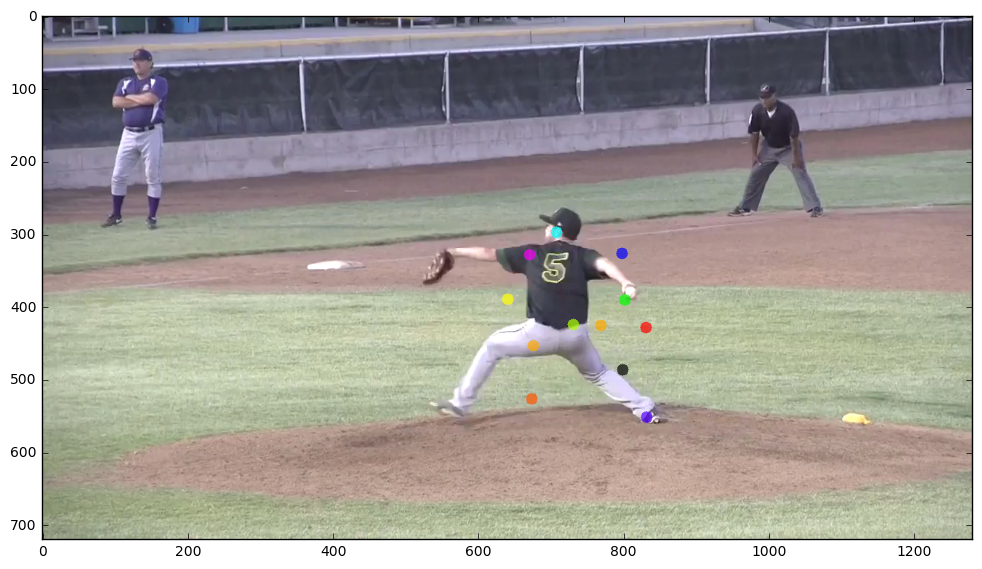

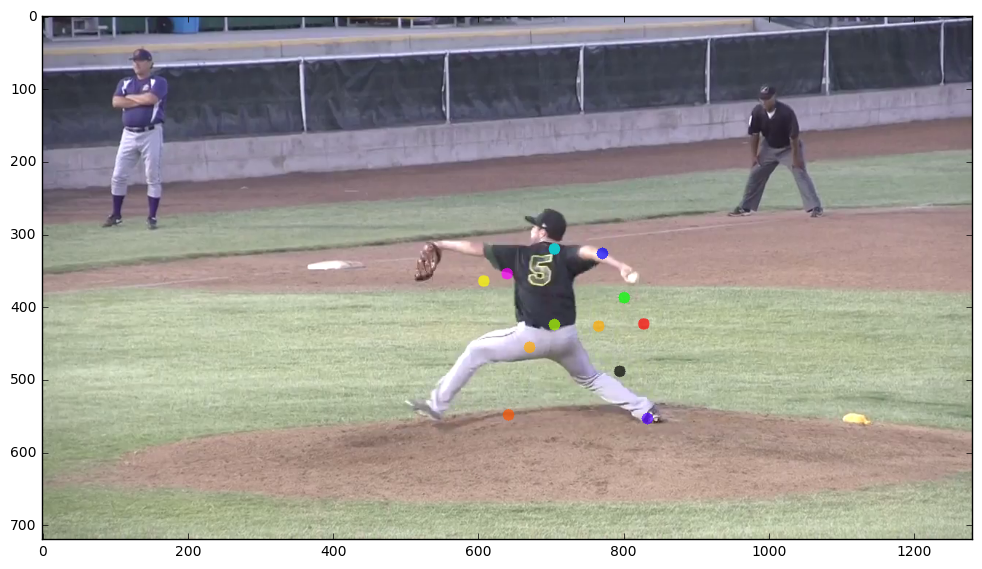

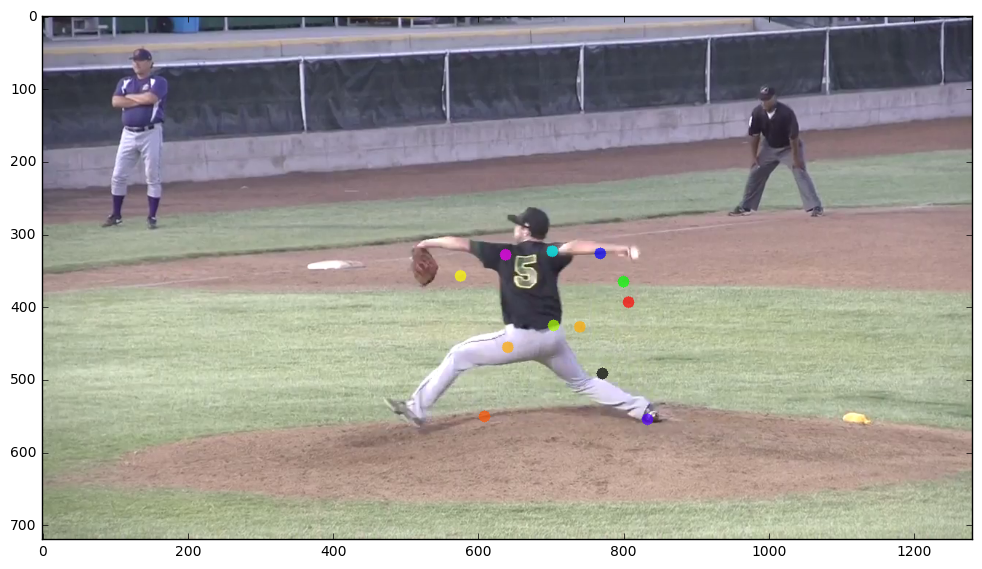

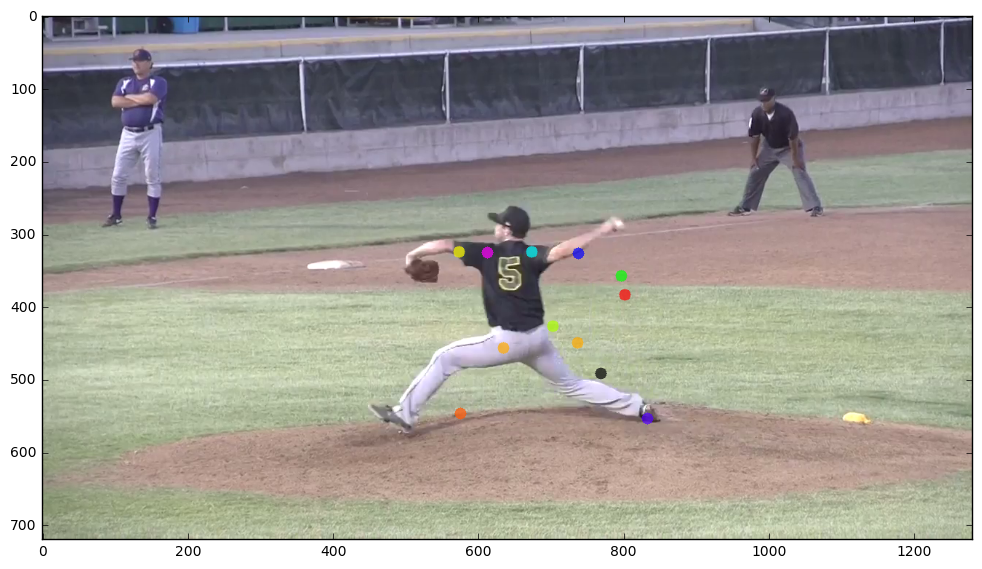

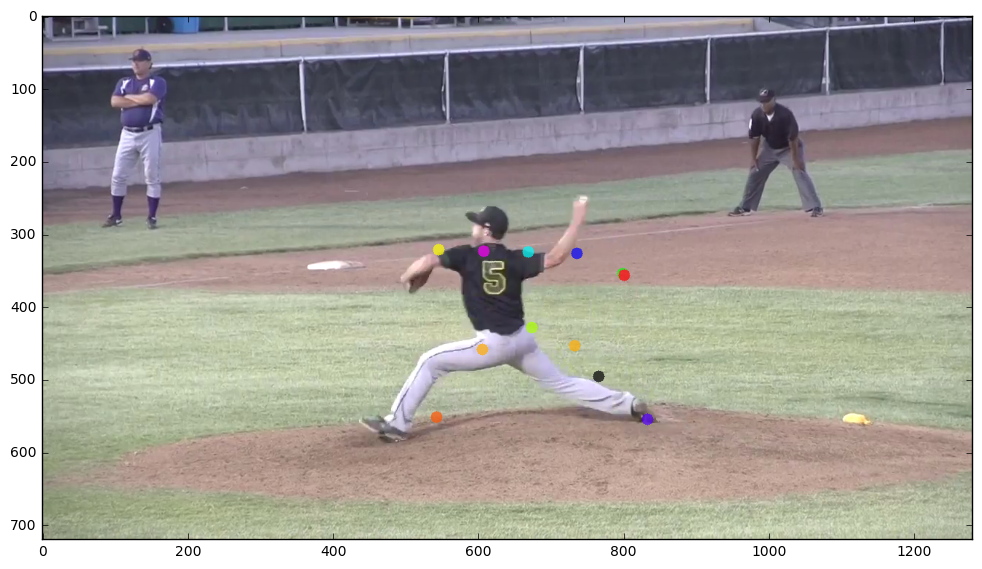

In [20]:
#name = "#48 RHP Tom Flippin 6-3 GO"
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"
outputs = "./sv/v0testing/" # + "handle_one_old/"
argmin_list = []
# df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one/"+name+".csv", dtype = {"Frame": np.int32, "Batter": np.ndarray})
for json_file in ["#5 RHP Matt Blais 5-3 GO (2).json"]: #listdir(outputs):
    name = json_file[:-5]
    if json_file[-5:]!= ".json" or json_file[-10:]=="local.json": # or name+".mp4" in listdir(outputs):
        print("wrong", json_file)
        continue
    print(name+".mp4")
    #with open(outputs+ name+".json", "r") as infile:
     #   handle_one_arr = json.load(infile)
    handle_one_arr = from_json(outputs+ name+".json")
    if name+".mp4" in listdir(path+"batter"):
        f = path+"batter/"+name+".mp4"
    else:
        f = path+"pitcher/"+name+".mp4"
    #name = "#5 RHP Matt Blais (4)"
    print(handle_one_arr.shape)
    print(np.array(handle_one_arr[0]).shape)
    print(f)

    #local_out = [elem.tolist() for elem in new_df]
        
    #with open(outputs+name+"_local.json", "w") as outfile:
     #   json.dump(local_out, outfile)
    

    #print(handle_one_arr[200:205])
    arr = color_video(handle_one_arr, f, start = 150, end = 155, cut_frame = False, plotting = True)#len(handle_one_arr)) #, printing = argmin_list)
    break
    # skvideo.io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one_bsp.mp4", arr)
    for i in range(12):
        for j in range(2):
            new_df[:,i,j] = kalmann(new_df[:,i,j]) #, window_len = 12, window = "flat")
    
    df_handle = [handle_one_arr, handle_one_arr.copy()]

    center = [dictionary[name][1],dictionary[name][0]] #[83, 102] # [ 182.,  601.] #
    new_df = np.array(df_coordinates(df_handle, np.array([center]), player_list)[1])
    print("out_df", np.array(new_df).shape)
    print(f)
    # new_df = ndimage.filters.gaussian_filter1d(np.array(new_df), axis = 0, sigma = 3)
    print(new_df.shape)
    plt.figure(figsize=(20,10))
    plt.plot(new_df[:,:12,0])
    plt.title("estelle")
    plt.show()
    arr2 = color_video(new_df[:,:12,:], f, start = 0, end =len(new_df), printing = None, plotting=False)
    io.vwrite(outputs+name+"_kalmann_stronger.mp4", arr2)

In [4]:
def color_video_two(json_array1, json_array2, vid_file, start = 0, end = 300, printing =None, plotting=True):
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 170, 255],
              [0, 0, 0], 
          [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], 
              [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], \
          [170, 0, 255], [255, 0, 170], [255, 0, 85]]
    colors_string = ["blue", "green", "red", "tuerkis", "pink", "yellow", "orange", "black", "purple"]
    nr_joints =12
    #print(json_array.shape)
    #writer = cv2.VideoWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi",cv2.VideoWriter_fourcc(*"XVID") , 20, (500,800))

    #writer = io.FFmpegWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi", (10,800,500,3))
    #writer.open()
    video_capture = cv2.VideoCapture(vid_file)
    print(vid_file)
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    arr = [] #np.zeros((100,800,500,3))
    
    bottom_b = 265
    left_b =499
    right_b= 703
    top_b = 99
    
    # fig = plt.figure(figsize=(5, 15)) # for subplots
    for k in range(start, end):
        #print(k)
        if printing!=None:
            #print("dist_min",  "ratio_min")
            #print(colors_string[printing[k][0]], colors_string[printing[k][1]])
            print(printing[k])
        ret, frame = video_capture.read()
        if frame is None:
            print("end", k)
            break
        if len(json_array1[k].shape)==2:
            all_peaks = np.reshape(json_array1[k], (12, 1,2))
            all_peaks2 = np.reshape(json_array2[k], (12, 1,2))
        else:
            all_peaks = json_array1[k]
            all_peaks2 = json_array2[k]
        #print(all_peaks.shape)
        
        canvas = frame #[top_b:bottom_b, left_b:right_b] # cv2.imread(f) # B,G,R order
        oriImg = canvas.copy()
        
        for i in range(len(all_peaks)):
            #print("person", all_peaks[i])
            for j in range(len(all_peaks[i])):
                cv2.circle(canvas, (int(all_peaks[i,j,0]),int(all_peaks[i,j,1])) , 2, colors[i], thickness=-1)
                cv2.circle(canvas, (int(all_peaks2[i,j,0]),int(all_peaks2[i,j,1])) , 2, colors[i], thickness=-1)
                

        to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
        arr.append(to_plot[:,:,[2,1,0]])
        if plotting:
            plt.imshow(to_plot[:,:,[2,1,0]])
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 12)
            plt.show()
    return np.array(arr)


def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

#arr2 = color_video(new_df[:,:12,:], f, start = 100, end =105, printing = None, plotting=True)



In [6]:
game = "fb2d39a6-49f9-4204-969b-1e0fbdfab7da.mp4" 
folder = "sv/test_outputs/"
#print(folder+game[:-4]+"_batter.json")
#print(game[:-4]+"_batter.json" in listdir("sv/"))
#print(listdir("sv/test_outputs/"))
new_df = from_json(folder+game[:-4]+"_batter.json")

#print(new_df.shape)
#print(new_df[:20])
f = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"+game #83764a69-2028-4530-8188-f7c37162d403.mp4"

new_df2 = from_json(folder + game[:-4]+"_pitcher.json")
print(new_df.shape, new_df2.shape)
arr2 = color_video_two(new_df[:,:12,:],new_df2[:,:12,:], f, start = 0, end =len(new_df), printing = None, plotting=False)
print(arr2.shape)
io.vwrite(folder+game, arr2)

(163, 12, 2) (163, 12, 2)
/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/fb2d39a6-49f9-4204-969b-1e0fbdfab7da.mp4
(163, 540, 960, 3)


In [22]:
folder = "/Volumes/Nina Backup/outputs/new_videos/cf/"
dic = {"490795": "2017-05-24", "490493":"2017-05-02", "490987":"2017-06-07", "491122":"2017-06-17", "491001":"2017-06-08", "491465":"2017-07-16"}
if folder[-3:]=="cf/":
    ext = ".mp4"
    view = "center field/"
else:
    ext = ".m4v"
    view = "side view/"
folder_list = listdir(folder)
for game in folder_list:
    if "batter" in game:
        print(game)
        continue
    
    #print(dic[game[:6]])
    if "new" in folder:
        video_folder = "/Volumes/Nina Backup/CENTERFIELD/"
        name = game.split("_")[1]
        begin = game.split("_")[0]
        json_name = begin+"_"+name
        if begin!="490770":
            continue
    else:
        video_folder = "/Volumes/Nina Backup/videos/atl/"+dic[game[:6]]+"/"+view
        #print(listdir(video_folder))
        json_name= name = game.split("_")[0]
        
    if name+ext in folder_list:
        print("already there", name)
        continue
    new_df = from_json(folder+json_name+"_batter.json")
    new_df2 = from_json(folder + json_name+"_pitcher.json")

    f = video_folder+name+ext #83764a69-2028-4530-8188-f7c37162d403.mp4"

    print(new_df.shape, new_df2.shape)
    arr2 = color_video_two(new_df[:,:12,:],new_df2[:,:12,:], f, start = 0, end =len(new_df), printing = None, plotting=False)
    print(arr2.shape)
    io.vwrite(folder+name+ext, arr2)

490770_ee78fe81-4a96-48cf-bb4d-83b5a9b487de_batter.json
490747_f26e2541-6312-4609-9331-218074bae592_batter.json
490762_a8247be3-82f7-4a0b-9da9-a67d8bc167c0_batter.json
490770_94495ba5-1949-4960-8a05-5b8cbeb620f1_batter.json
(165, 12, 2) (165, 12, 2)
/Volumes/Nina Backup/CENTERFIELD/be1a7f10-c4a3-4977-9bab-805fcef4d248.mp4
(165, 540, 960, 3)
490747_be7b9bf9-0326-4eb7-936a-17b6c6e0edfe_batter.json
490762_a545050c-cfb2-4970-b019-d94837c3aa35_batter.json
(166, 12, 2) (166, 12, 2)
/Volumes/Nina Backup/CENTERFIELD/83b46bcb-99ac-4218-96f1-d602e8bc9067.mp4
(166, 540, 960, 3)
490747_6c52d0a5-d637-4414-874e-1d8de245e73b_batter.json
490762_352c2104-1b10-4544-8306-25f43c377661_batter.json
490747_522f9dd5-796f-4f30-b0d1-20b0558516b5_batter.json
490747_370e6609-6294-418c-8422-9192d7417f8d_batter.json
490762_1d3dfcb2-55de-4f69-945c-d472224b1b91_batter.json
490747_2938d3e2-d8a4-45af-90b5-ba565b784a30_batter.json
490762_20c065a7-5aa6-40ca-a74e-c9678551a0d9_batter.json
490747_60f2b5a7-0c00-44e3-abf8-e4b

KeyboardInterrupt: 

# Save colored video from directory

In [ ]:
from os import listdir
dire = listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/")
for fi in dire:
    filename = fi.split("_")[0] #"#33 Logan Trowbridge"
    print(filename)
    if filename[-4:]==".mp4": #or filename+".mp4" in dire:
        print("already there")
        continue
    if filename+".mp4" in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter"):
        player = "batter/"
    else:
        player = "pitcher/"


    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 0, 0], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]


    cmap = matplotlib.cm.get_cmap('hsv')

    vid_file = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"+player+filename+".mp4"
    json_array = from_json("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"+filename+"_joints.json")
    # = np.swapaxes(np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/handle_one_bsp.npy"), 0,1)
    nr_joints = 12
    print(json_array.shape)


    arr = color_video(json_array, vid_file, plotting = False)
    skvideo.io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"+filename+".mp4", arr)

# Build center dic

In [ ]:
#with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "r") as infile:
 #   dictionary = json.load(infile)

in_folder = listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher")
for i in in_folder:
    if i[:-4] not in dictionary.keys():
        print(i)

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter/"
f = '#25 Trevor DeMerritt rbi base hit.mp4'
print(f[:-4] in dictionary.keys())

center = dictionary[f[:-4]] #[1200,650]
cap  = cv2.VideoCapture(path+f)
ret, frame = cap.read()
cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
plt.imshow(frame)
plt.show()

dictionary[f[:-4]]=center

### Test for all files

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"

for fi in dictionary.keys():
    f = fi+'.mp4'
    print(f)
    # print(f[:-4] in dictionary.keys())
    if f in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter"):
        continue
    center = dictionary[fi] #[700,650]
    print(center)

    cap  = cv2.VideoCapture(path+f)
    ret, frame = cap.read()
    cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
    plt.imshow(frame)
    plt.show()

    #dictionary[f[:-4]]=center

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "r") as infile:
    dictionary = json.load(infile)

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"
f = '#5 RHP Matt Blais (3).mp4'
print(f[:-4] in dictionary.keys())

center = dictionary[f[:-4]] #[1200,650]
cap  = cv2.VideoCapture(path+f)
i = 0
while True:
    ret, frame = cap.read()
    if frame is None:
        print(i-1)
        plt.imshow(prev_frame)
        plt.show()
        break
    # cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
    prev_frame = frame
    i+=1

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/test_functions.json","r") as infile:
    images = json.load(infile)
print(len(images))

In [ ]:
for i in images:
    plt.imshow(i)
    plt.show()

In [26]:
from osgeo import ogr

ImportError: No module named 'osgeo'